# Advanced Lane Finding (Project 2 - Self-Driving Car Engineer ND)

The goals / steps of this project are the following:

    * Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    * Apply a distortion correction to raw images.
    * Use color transforms, gradients, etc., to create a thresholded binary image.
    * Apply a perspective transform to rectify binary image ("birds-eye view").
    * Detect lane pixels and fit to find the lane boundary.
    * Determine the curvature of the lane and vehicle position with respect to center.
    * Warp the detected lane boundaries back onto the original image.
    * Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Imports

In [363]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpl_img
import glob

#test_image = plt.imread("test_images/straight_lines1.jpg")
test_image = plt.imread("test_images/test4.jpg")
plt.imsave("output_images/original_image.jpg", test_image)

## Camera Calibration


In [364]:
def calibrateCamera():
    """
    Calculates parameters needed for camera calibration with the help of the calibration files
    """
    # Load images from folder camera_cal with the help of the glob library
    images = glob.glob("camera_cal/calibration*.jpg")

    # Arrays to save object~ / image points from all images
    obj_points = []
    img_points = []

    # Preperation of objectpoints 
    objp = np.zeros((6*9,3), np.float32)
    for y in range(6):
        for x in range(9):
            objp[9*y+x] = [x,y,0]

    # Loop over all calibration images
    for image_path in images:
        # Read in image
        image = mpl_img.imread(image_path)

        # Convert Image to gray scale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        img = cv2.drawChessboardCorners(image, (9,6), corners, ret)

        if ret:
            img_points.append(corners)
            obj_points.append(objp)

    return obj_points, img_points

op, ip = calibrateCamera()

## Image distortion correction

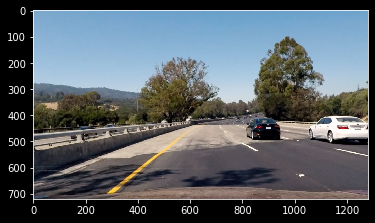

In [365]:
def undistortImage(image, o_points, i_points):
    """
    Undistort Images from a camera
    INPUT: distorted image, object_points, image_points (both from calibrateCamera())
    OUTPUT: undistorted image or error on failure
    """
    # Convert to gray scale
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Calculate Camera matrix and distance coefficients 
    ret, cam_matrix, distance_coeff, rot_vec, trans_vec = cv2.calibrateCamera(o_points, i_points, gray.shape, None, None)
    if ret:
        # return undistorted image
        return cv2.undistort(image, cam_matrix, distance_coeff)
    else:
        # raise error if camera calibration fails
        raise ValueError("Can not undistort the given image!")

undistort_img = undistortImage(test_image, op, ip)
plt.imshow(undistort_img)
plt.imsave("output_images/undistorted_image.jpg", undistort_img)

## Thresholded binary image generation

In [366]:
def show_channels(rgb_image):#
    """
    This function shows all channels from RGB, HSV and HSL images
    """
    r = rgb_image[:,:,0]
    g = rgb_image[:,:,1]
    b = rgb_image[:,:,2]
    
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]

    hls = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)
    
    red_image = np.copy(rgb_image)
    red_image[:,:,1] = 0
    red_image[:,:,2] = 0
    g_image = np.copy(rgb_image)
    g_image[:,:,0] = 0
    g_image[:,:,2] = 0
    b_image = np.copy(rgb_image)
    b_image[:,:,0] = 0
    b_image[:,:,1] = 0
    
    f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(40,40))
    ax1.set_title('R channel')
    ax1.imshow(r, cmap='gray')
    ax2.set_title('G channel')
    ax2.imshow(g, cmap='gray')
    ax3.set_title('B channel')
    ax3.imshow(b, cmap='gray')
    
    f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(40,40))
    ax1.set_title('H channel')
    ax1.imshow(h, cmap='gray')
    ax2.set_title('S channel')
    ax2.imshow(s, cmap='gray')
    ax3.set_title('V channel')
    ax3.imshow(v, cmap='gray')

    f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(40,40))
    ax1.set_title('H channel')
    ax1.imshow(hls[:,:,0], cmap='gray')
    ax2.set_title('L channel')
    ax2.imshow(hls[:,:,1], cmap='gray')
    ax3.set_title('S channel')
    ax3.imshow(hls[:,:,2], cmap='gray')

    f, (ax1) = plt.subplots(1, 1, figsize=(40,40))
    ax1.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY), cmap='gray')

#show_channels(undistort_img)

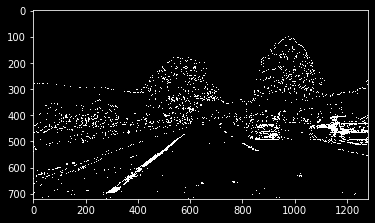

In [367]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Function calculates the directional gradient and applies given thresholds as binary mask
    INPUT:  img = RGB image
            orient = 'x' or 'y'
            sobel_kernel = Sobel kernel size, odd positive number
            threshold = Tuple of lower and upper threshold
    OUTPUT: binary image
    """
    # 1) Pick the value channel from HSV convertion
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    # 2) Take the derivative in given orientation = 'x' or 'y'
    sobel = cv2.Sobel(v, cv2.CV_64F, orient == 'x', orient == 'y')
    # 3) Take the absolute value of the derivative of gradient
    absSobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    uint8_sobel = np.uint8(255*absSobel/np.max(absSobel))
    # 5) Create a binary mask
    grad_binary = np.zeros_like(uint8_sobel)
    grad_binary[(uint8_sobel > thresh[0]) & (uint8_sobel < thresh[1])] = 1

    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    Function calculates the gradient magnitude and applies given thresholds as binary mask
    INPUT:  img = RGB image
            sobel_kernel = Sobel kernel size, odd positive number
            threshold = Tuple of lower and upper threshold
    OUTPUT: binary image
    """
    # 1) Pick the value channel from HSV convertion
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(v, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(v, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    magnitude = np.sqrt(sobelx ** 2 + sobely ** 2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled = np.uint8(255 * magnitude / np.max(magnitude))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled)
    mag_binary[(scaled > mag_thresh[0]) & (scaled < mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Function calculates the gradient direction and applies given thresholds as binary mask
    INPUT:  img = RGB image
            sobel_kernel = Sobel kernel size, odd positive number
            threshold = Tuple of lower and upper threshold
    OUTPUT: binary image
    """
    # 1) Pick the value channel from HSV convertion
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    # 2) Take the gradient in x and y separately
    xSobel = cv2.Sobel(v, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    ySobel = cv2.Sobel(v, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    x_abs = np.absolute(xSobel)
    y_abs = np.absolute(ySobel)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(y_abs, x_abs)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction > thresh[0]) & (direction < thresh[1])] = 1
    return dir_binary

def create_thresholded_binary_image(rgb_image):
    """
    Function takes in an RGB image and returns an thresholded binary image with the lane lines 
    """
    # Thresholds
    lower_s_threshold = 180
    upper_s_threshold = 255

    # Color conversions
    hls = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)
    s_hls = hls[:,:,2]

    # Color thresholds
    color_based_threshold = (s_hls > lower_s_threshold) & (s_hls <= upper_s_threshold)

    # Sobel thresholds
    ksize = 1 # Sobel kernel size

    gradx = abs_sobel_thresh(rgb_image, orient='x', sobel_kernel=ksize, thresh=(25, 100)) #20, 50
    grady = abs_sobel_thresh(rgb_image, orient='y', sobel_kernel=ksize, thresh=(25, 100)) #20, 50
    mag_binary = mag_thresh(rgb_image, sobel_kernel=ksize, mag_thresh=(35, 85))
    dir_binary = dir_threshold(rgb_image, sobel_kernel=ksize, thresh=(np.pi/4, 4*np.pi/10)) # np.pi/4, np.pi/3

    sobel_based_threshold = ((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))

    # Binary image creation
    binary = np.zeros_like(s_hls)
    binary[(color_based_threshold | sobel_based_threshold)] = 1

    return binary

thresholded_img = create_thresholded_binary_image(undistort_img)
plt.imsave("output_images/thresholded_image.jpg", thresholded_img)
plt.imshow(thresholded_img, cmap="gray")

## Transformation to "bird-view"

1280


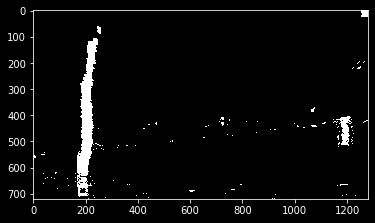

In [368]:
def transform_road(binary_image):

    # Image size
    xsize = binary_image.shape[1]
    ysize = binary_image.shape[0]
    print(xsize)
    
    # Display Area on binary Image
    #cv2.line(binary_image, (90, ysize), (554, 465), 1, thickness=5)
    #cv2.line(binary_image, (735, 465), (554, 465), 1, thickness=5)
    #cv2.line(binary_image, (735, 465), (xsize-20, ysize), 1, thickness=5)
    #implot = plt.imshow(binary_image, cmap="gray")
    #plt.scatter(x=[560, 745, 130, xsize-125], y=[465, 465, ysize, ysize], c='r', s=40)
    #plt.show()

    # Select source points
    src = np.float32([[554, 465], [735, 465], [90, ysize], [xsize, ysize]])

    # Select destination points
    dest = np.float32([[0,0],[xsize,0],[0, ysize],[xsize,ysize]])

    # Perform transformation
    M = cv2.getPerspectiveTransform(src, dest)
    Minv = cv2.getPerspectiveTransform(dest, src)
    warped = cv2.warpPerspective(binary_image, M, (xsize, ysize), flags=cv2.INTER_LINEAR)

    return warped, Minv
    
transformed_img, M_inv = transform_road(thresholded_img)
plt.imshow(transformed_img, cmap="gray")
plt.imsave("output_images/transformed_image.jpg", transformed_img)

## Detect Lane Lines

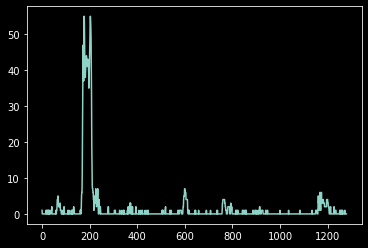

In [369]:
def showHistogram(trans_img, tenth):
    part_of_image = trans_img[int((tenth-1)*trans_img.shape[0]/10):int(tenth*trans_img.shape[0]/10), :]
    histogram = np.sum(part_of_image, axis=0)
    plt.plot(histogram)

showHistogram(transformed_img, 10)

In [370]:
def find_lane_line_pixels(trans_img):
    # Image size
    xsize = trans_img.shape[1]
    ysize = trans_img.shape[0]

    # Create an output image
    out_img = np.dstack((trans_img, trans_img, trans_img))
    plt.imshow(trans_img)

    # Calculate initial left and right x
    part_of_image = trans_img[int(trans_img.shape[0]//2):, :]
    histogram = np.sum(part_of_image, axis=0)

    middle = np.int(histogram.shape[0]/2)
    init_leftx = np.argmax(histogram[:middle])
    init_rightx = np.argmax(histogram[middle:]) + middle

    # Parameters
    n_window = 10
    window_height = np.int(ysize / n_window)
    margin = 100 # margin for window size
    minpx = 50 # minimal ammount of changed pixels

    # Nonzero pixels
    nonzero = trans_img.nonzero()
    nonzeroY = np.array(nonzero[0])
    nonzeroX = np.array(nonzero[1])

    # Current position
    current_leftx = init_leftx
    current_rightx = init_rightx

    left_lane_ind = []
    right_lane_ind = []

    # Loop through windows
    for window in range(n_window):
        # Calculate window boundaries
        win_y_low = ysize - ((window + 1) * window_height) # Start at bottom of image and move upwards
        win_y_high = ysize - (window * window_height)      # Start at bottom of image and move upwards
        win_xleft_low = current_leftx - margin
        win_xleft_high = current_leftx + margin
        win_xright_low = current_rightx - margin
        win_xright_high = current_rightx + margin

        # Draw the windows on the visualization image
        # TODO: Remove!
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify nonzeros in windows
        good_left_inds = ((nonzeroY >= win_y_low) & (nonzeroY <= win_y_high) & (nonzeroX >= win_xleft_low) & (nonzeroX <= win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroY >= win_y_low) & (nonzeroY <= win_y_high) & (nonzeroX >= win_xright_low) & (nonzeroX <= win_xright_high)).nonzero()[0]
        left_lane_ind.append(good_left_inds)
        right_lane_ind.append(good_right_inds)

        # If enough pixels identified, change current position
        if (len(good_left_inds) >= minpx):
            current_leftx = np.int(sum(nonzeroX[good_left_inds])/len(nonzeroX[good_left_inds]))
        if (len(good_right_inds) >= minpx):
            current_rightx = np.int(sum(nonzeroX[good_right_inds])/len(nonzeroX[good_right_inds]))

    # Concatente arrays of indices
    left_lane_ind = np.concatenate(left_lane_ind)
    right_lane_ind = np.concatenate(right_lane_ind)

    # Extract left and right line pixel positions
    leftx = nonzeroX[left_lane_ind]
    lefty = nonzeroY[left_lane_ind] 
    rightx = nonzeroX[right_lane_ind]
    righty = nonzeroY[right_lane_ind]

    return leftx, lefty, rightx, righty, out_img

In [371]:
def calulateXgivenY(y, a, b, c, width):
    """
    Calculate Y given X and return POSITIVE, reasonable value
    """
    x1 = (-b + np.sqrt(b**2 - 4*a*(c-y)))/(2*a)
    x2 = (-b - np.sqrt(b**2 - 4*a*(c-y)))/(2*a)
    return x1, x2
    if (x1 > 0 and ((x1 < 400) or (x1 > (width - 400)) and x1 < width)):
        return x1
    elif (x2 > 0 and ((x2 < 400) or (x2 > (width - 400)) and x2 < width)):
        return x2
    return 0

Left curvature: 1594.2045246264188 m
Right curvature: 585.2097082042623 m
Total: 1089.7071164153406 m
Left x: 0.7166249462637128 m
Right x: 4.435182095813752 m
Lane center: 2.5759035210387324 m
Lane width: 3.718557149550039 m
Car offset: -0.1839843291195402 m


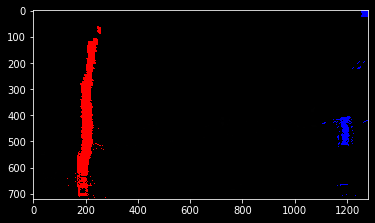

In [372]:
def fit_poly(trans_img):
    leftx, lefty, rightx, righty, out_img = find_lane_line_pixels(trans_img)

    # Image dimensions
    ysize = trans_img.shape[0]
    xsize = trans_img.shape[1]

    # Meters in pixel
    ym_per_pix = 22/720
    xm_per_pix = 3.7/990

    # Calculate polynomial fit 
    left_fit = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, (trans_img.shape[0]-1), trans_img.shape[0])

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx / xm_per_pix, ploty / ym_per_pix, color='yellow')
    #plt.plot(right_fitx / xm_per_pix, ploty / ym_per_pix, color='yellow')

    ## Curvature calculation
    y_eval = np.max(ploty) * ym_per_pix # y at which radius is calculated

    # Left and right lane curvature calculation
    left_curvature = np.sqrt((1+(2*left_fit[0]*y_eval+left_fit[1])**2)**3)/np.abs(2*left_fit[0])
    right_curvature = np.sqrt((1+(2*right_fit[0]*y_eval+right_fit[1])**2)**3)/np.abs(2*right_fit[0])

    # Mean of the left and right lane curvature
    curvature = np.mean((left_curvature, right_curvature))

    ## Position calculation
    # x positions of lines
    left_line_x = left_fit[0] * y_eval ** 2 + left_fit[1] * y_eval + left_fit[2]
    right_line_x = right_fit[0] * y_eval ** 2 + right_fit[1] * y_eval + right_fit[2]

    # x position of lane center
    lane_center_x = (right_line_x+left_line_x)/2
    #plt.scatter(x=[lane_center_x / xm_per_pix], y=[ysize], c='r', s=40)
    
    car_center = xsize * xm_per_pix / 2
    frame_offset = 90*xm_per_pix
    car_offset = car_center - (lane_center_x)# + frame_offset)


    print("Left curvature: " +  str(left_curvature) + " m")
    print("Right curvature: " +  str(right_curvature) + " m")
    print("Total: " + str(curvature) + " m")

    print("Left x: " +  str(left_line_x) + " m")
    print("Right x: " +  str(right_line_x) + " m")
    print("Lane center: " + str(lane_center_x) + " m")
    print("Lane width: " + str(right_line_x - left_line_x) + " m")
    print("Car offset: " + str(car_offset) +  " m")

    ## Warp image back
    #warp_zero = np.zeros_like(trans_img).astype(np.uint8)
    #color_warp = out_img #np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    #pts_left = np.array([np.transpose(np.vstack([left_fitx / xm_per_pix, ploty / ym_per_pix]))])
    #pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx / xm_per_pix, ploty / ym_per_pix])))])
    #pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    #newwarp = cv2.warpPerspective(color_warp, M_inv, (test_image.shape[1], test_image.shape[0])) 
    # Combine the result with the original image
    #result = cv2.addWeighted(undistort_img, 1, newwarp, 0.3, 0)
    #plt.imshow(result)

    return out_img, left_fitx, right_fitx, ploty, curvature, car_offset
    #return result, left_fitx, right_fitx, ploty

identified_lines_image, lfx, rfx, p, r, o = fit_poly(transformed_img)
plt.imshow(identified_lines_image)
plt.imsave("output_images/identified_image.jpg", identified_lines_image)

## Warp results back to the image

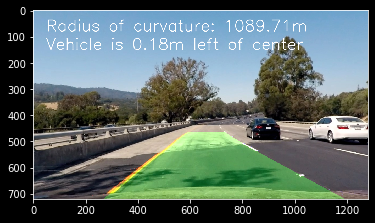

In [373]:
def warpBackResults(warped_img, color_img, Minv, left_fitx, right_fitx, ploty, radius, offset):
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = color_img

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (test_image.shape[1], test_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistort_img, 1, newwarp, 0.3, 0)

    ## Write text to image
    font = cv2.FONT_HERSHEY_SIMPLEX
    line1 = "Radius of curvature: " + str(np.around(radius, decimals=2)) + "m"
    if offset < 0:
        line2 = "Vehicle is " + str(np.abs(np.around(offset, decimals=2))) + "m left of center"
    else:
        line2 = "Vehicle is " + str(np.abs(np.around(offset, decimals=2))) + "m right of center"
    cv2.putText(result, line1, (50,80), font, 2, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(result, line2, (50,150), font, 2, (255,255,255), 2, cv2.LINE_AA)


    plt.imshow(result)
    plt.imsave("output_images/final_image.jpg", result)

# Meters in pixel
ym_per_pix = 22/720
xm_per_pix = 3.7/990
warpBackResults(transformed_img, identified_lines_image, M_inv, lfx / xm_per_pix, rfx / xm_per_pix, p / ym_per_pix, r, o)